In [2]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os
# Visualization
from IPython.display import Image, display
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [67]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=True,
                      max_num_hands=1,
                      min_detection_confidence=0.75,
                      min_tracking_confidence=0.75,
                      model_complexity=0)
mpDraw = mp.solutions.drawing_utils

dataset_path = 'asl_alphabet_train/ASLMODEL'  # Update this path to your dataset location

def process_and_display_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    
    # Process the image
    results = hands.process(img)
    
    if results.multi_hand_landmarks:
        # Draw hand landmarks
        h, w, c = img.shape
        min_x, min_y = w, h
        max_x, max_y = 0, 0
        for id, lm in enumerate(results.multi_hand_landmarks[0].landmark):
            cx, cy = int(lm.x * w), int(lm.y * h)

            min_x, min_y = min(min_x, cx), min(min_y, cy)
            max_x, max_y = max(max_x, cx), max(max_y, cy)
        
        center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
        width, height = 1.3*(max_x - min_x), 1.3*(max_y - min_y)
        
        new_min_x, new_min_y = int(center_x - width / 2), int(center_y -  height / 2)
        new_max_x, new_max_y = int(center_x + width / 2), int(center_y +  height / 2)
        
        cv2.rectangle(img, (new_min_x, new_min_y), (new_max_x, new_max_y), (255, 255, 25), 1)
        hand_region = img[new_min_y:new_max_y, new_min_x:new_max_x]
        
        filename= '/ASLMODELCROPPED/'+ image_path.split('/')[-1]
        print(filename)
        cv2.imwrite(filename, hand_region)
        
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print('No hand detected in:', image_path)


for class_dir in os.listdir('asl_alphabet_train/ASLMODEL')[::-1]:
    class_path = os.path.join('asl_alphabet_train/ASLMODEL', class_dir)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            process_and_display_image(image_path)

No hand detected in: asl_alphabet_train/ASLMODEL\W\W1.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W10.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W100.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1000.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1001.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1002.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1003.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1004.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1005.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1006.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1007.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1008.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1009.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W101.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1010.jpg
No hand detected in: asl_alphabet_train/ASLMODEL\W\W1011.jpg
No hand detected in: asl_alphab

KeyboardInterrupt: 

In [69]:




# ImageDataGenerator without augmentation, only rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values from [0, 255] to [0, 1] for neural network processing
    validation_split=0.2  # Assuming you want to split your dataset into training and validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    'asl_alphabet_train/ASLMODEL',  # Replace with your actual directory path
    target_size=(64, 64),  # Resize images to 200x200
    batch_size=32,
    class_mode='categorical',  # Since you're doing multi-class classification
    subset='training'  # Specify as training data
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    'asl_alphabet_train/ASLMODEL',  # Same directory, ImageDataGenerator will split the data
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify as validation data
)


Found 21600 images belonging to 9 classes.
Found 5400 images belonging to 9 classes.


In [70]:
model = Sequential([
    layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(64, 64, 3)),  # Adjusted for RGB images
    layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPool2D(2),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dropout(0.2),
    
    layers.Dense(9, activation='softmax')  # Adjusted for 14 classes
])
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Summary of model
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_45 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        9248      
                                                     

In [71]:
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 1e-4,
    patience = 5,
    restore_best_weights = True
)
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    factor = 0.5,
    min_lr = 1e-5
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    callbacks=[earlyStopping, reduceLR],
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    workers=4,
    use_multiprocessing=False,
    epochs=10  # You can adjust the number of epochs based on your model's performance and training needs
)

Epoch 1/10
675/675 [==============================] - 734s 1s/step - loss: 0.8522 - accuracy: 0.6853 - val_loss: 0.6774 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 2/10
675/675 [==============================] - 650s 963ms/step - loss: 0.0997 - accuracy: 0.9674 - val_loss: 0.6981 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 3/10
675/675 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9856

KeyboardInterrupt: 

In [73]:
AlternateModel = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(640, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax')  # Adjusted for 14 classes
])
AlternateModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Summary of model
AlternateModel.summary()

AlternateHistory = AlternateModel.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    callbacks=[earlyStopping, reduceLR],
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    workers=4,
    use_multiprocessing=False,
    epochs=10  # You can adjust the number of epochs based on your model's performance and training needs
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_49 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 12, 12, 128)     

In [76]:
#AlternateModel.save('ASLModelV3.h5')
AlternateModel.classes()

AttributeError: 'Sequential' object has no attribute 'classes'

In [1]:
from tensorflow.keras.utils import plot_model


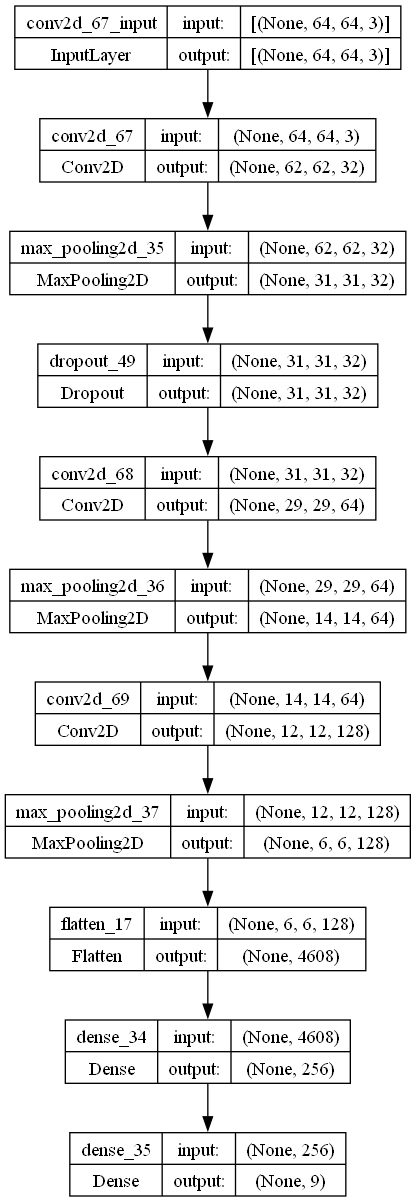

In [3]:
AltModel=load_model('ASLModelV3.h5')
plot_model(AltModel, show_shapes=True, show_layer_names=True)